# Convolutional Neural Networks in Pytorch

In [ ]:
# Convolutional NNs accept 2D or 3D inputs
# Kernel = Window -> (3,3) for exaple that interated over it
# Detect edges, curves, corners etc. -> Second Layer: Find more complex features that edges, corners and curves build (Circles, Squares etc.)

# Pooling: Window -> for example maxpooling, take the maximum value. 

# Conv + MaxPool = HL  Simplify image and look for features 

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False # If you set this true, then the images will be loaded one by one. Since this has alread be done, we do not have to do it anymore. 
# However, if you want to do it, place the folder "PetImages" which is on "/Users/dj/Documents/Python" into the same directory as this jupyter notebook

class DogsVSCats():
    IMG_SIZE = 50 # Make images 50 * 50 -> Because we have different shapes
    CATS = '/Users/dj/Documents/GitHub/Neural-Networks-/Pytorch/PetImages/Cat/'
    DOGS = '/Users/dj/Documents/GitHub/Neural-Networks-/Pytorch/PetImages/Dog/'
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
                for f in tqdm(os.listdir(label)):
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                    except Exception as e:
                        # print(str(e))
                        pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)


if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [4]:
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [2]:
training_data = np.load("training_data.npy", allow_pickle = True)
print(len(training_data))

24946


In [30]:
print(training_data[1])

[array([[216, 224, 205, ...,  72,  69,  51],
       [214, 213, 215, ...,  89,  54,  53],
       [219, 211, 209, ...,  99,  69,  47],
       ...,
       [200, 220, 220, ..., 236, 240, 242],
       [200, 207, 217, ..., 237, 239, 243],
       [203, 214, 217, ..., 238, 241, 237]], dtype=uint8)
 array([0., 1.])]


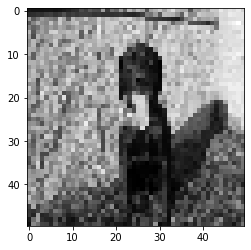

In [41]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0], cmap = "gray")
plt.show()

In [44]:
training_data[1][1] # [1,0] = cat, [0,1] = dog

array([0., 1.])

# Video 6

In [ ]:
training_data = np.load("training_data.npy", allow_pickle = True)
print(len(training_data))

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32, 5) # 1 = input, 32 concolutional feature, 5 = (5,5) kernel size
        self.conv2 = nn.Conv2d(32,64, 5)
        self.conv3 = nn.Conv2d(64,128, 5)

        # Somehow, one has to flatten it to a output of 2 (cats, dogs), but this seems to be poorly explained by the pytorch documentation
        # self.fc1 = nn.Linear(???, 521) <- How to get the ???

        x = torch.randn(50,50).view(-1, 1,50,50) # -1 = However many input features we have, 1 = one image with shape 50,50 -> Tensor (1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) # We have to run the network one in order to get the number self._to_linear
        self.fc2 = nn.Linear(512, 2) # 2 for cats and dogs

    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) # (2,2) = shape of pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2] # 3 Numbers
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # <- flattening  # We have to run the network one in order to get the number self._to_linear - here as well
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1) # dim = 1 because of the batches | The x comes as a batch of x's | dim = 0 would be everything, 1 is like a column vector cats and dogs

net = Net()

torch.Size([128, 2, 2])
